### Load raw transaction-level visit data

Import required libraries, and load the anonymized transaction-level dataset for exploratory analysis.

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

df = pd.read_csv("../data/raw/visits_2024_2025_cleaned.csv")
df.head()

,Branch ID,Region,Site Type,Visit Date,Ticket#,Visit Type,Appt Booked Date,Service Time,Appt Scheduled Time,Arrival Time,Call Time,End Treatment Time,max_wickets
0,#056,West,Internal,2024-03-18,A1020,Appointment,2024-03-15,00:14:56,14:47:27,10:15:46,10:21:01,10:40:26,5.0
1,#003,Central,External,2024-03-18,E022,Walk-in,NaN,00:08:17,10:20:40,10:20:50,10:49:21,11:04:11,22.0
2,#003,Central,External,2024-03-18,E023,Walk-in,NaN,00:01:37,10:21:07,10:21:18,10:49:42,10:57:44,22.0
3,#044,Central,Internal,2024-03-18,W009,Walk-in,NaN,00:08:18,10:21:19,10:21:19,10:30:01,10:42:02,5.0
4,#003,Central,External,2024-03-18,H048,Walk-in,NaN,00:10:41,10:21:36,10:21:41,11:01:59,11:30:58,22.0


### Prepare timestamps and construct wait-time target

Parse raw date and time fields into proper datetime objects, then derive the customer wait-time duration as the difference between arrival and service start. This step standardizes temporal fields and creates the primary target variable used throughout the analysis.

In [ ]:
# Convert date / time columns to datetime 

time_cols = [
    "Visit Date",
    "Arrival Time",
    "Call Time",
    "End Treatment Time",
    "Appt Booked Date",
    "Appt Scheduled Time"
    ]
for col in time_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

# Compute wait time (in minutes) 
df["wait_time_min"] = (
    df["Call Time"] - df["Arrival Time"]
    ).dt.total_seconds() / 60

In [55]:
df.head()

,Branch ID,Region,Site Type,Visit Date,Ticket#,Visit Type,Appt Booked Date,Service Time,Appt Scheduled Time,Arrival Time,Call Time,End Treatment Time,max_wickets,wait_time_min
0,#056,West,Internal,2024-03-18,A1020,Appointment,2024-03-15,00:14:56,2026-01-03 14:47:27,2026-01-03 10:15:46,2026-01-03 10:21:01,2026-01-03 10:40:26,5.0,5.250000
1,#003,Central,External,2024-03-18,E022,Walk-in,NaT,00:08:17,2026-01-03 10:20:40,2026-01-03 10:20:50,2026-01-03 10:49:21,2026-01-03 11:04:11,22.0,28.516667
2,#003,Central,External,2024-03-18,E023,Walk-in,NaT,00:01:37,2026-01-03 10:21:07,2026-01-03 10:21:18,2026-01-03 10:49:42,2026-01-03 10:57:44,22.0,28.400000
3,#044,Central,Internal,2024-03-18,W009,Walk-in,NaT,00:08:18,2026-01-03 10:21:19,2026-01-03 10:21:19,2026-01-03 10:30:01,2026-01-03 10:42:02,5.0,8.700000
4,#003,Central,External,2024-03-18,H048,Walk-in,NaT,00:10:41,2026-01-03 10:21:36,2026-01-03 10:21:41,2026-01-03 11:01:59,2026-01-03 11:30:58,22.0,40.300000


### Inspect dataset structure and validate transaction-level records

Summarize the size, coverage, and categorical composition of the dataset, and perform basic sanity checks to ensure transaction-level records are internally consistent before aggregation and modeling.

In [56]:
# Quick look at categorical distributions
cat_cols = ["Region", "Site Type", "Visit Type"]

for col in cat_cols:
    print(f"\n{col} value counts:")
    print(df[col].value_counts(dropna=False).head(10))


Region value counts:
Region
Central    1581697
West        676096
East        456969
North         7958
Name: count, dtype: int64

Site Type value counts:
Site Type
External    1735963
Internal     986757
Name: count, dtype: int64

Visit Type value counts:
Visit Type
Walk-in        2200789
Appointment     521931
Name: count, dtype: int64


In [57]:
# Sanity checks on wait times
df["wait_time_min"].describe()

count    2.722720e+06
mean     1.595262e+01
std      1.692288e+01
min      5.000000e-01
25%      4.450000e+00
50%      1.081667e+01
75%      2.076667e+01
max      3.572500e+02
Name: wait_time_min, dtype: float64

### Examine wait-time distribution and assess extreme values  
Visualize the distribution of transaction-level wait times to assess skewness and the presence of extreme delays, and define pragmatic bounds for exploratory analysis while retaining full variability for downstream modeling.

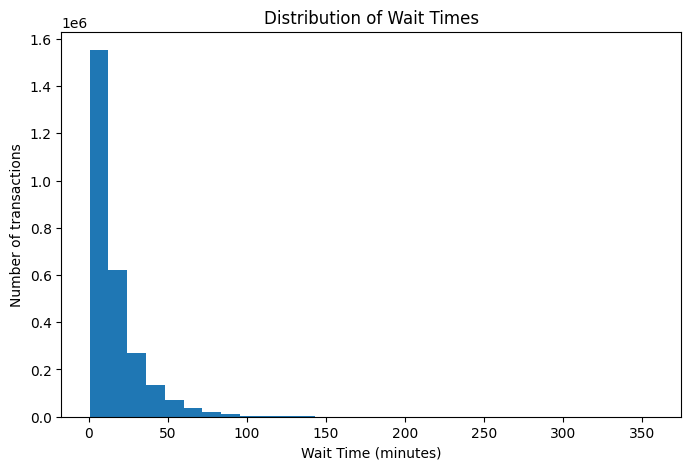

In [58]:
plt.figure(figsize=(8, 5))
plt.hist(df["wait_time_min"], bins=30)
plt.title("Distribution of Wait Times")
plt.xlabel("Wait Time (minutes)")
plt.ylabel("Number of transactions")
plt.show()

In [59]:
# Inspect high-end tail
df["wait_time_min"].quantile([0.95, 0.99, 0.995, 0.999])

0.950     49.400000
0.990     79.566667
0.995     93.666667
0.999    132.121350
Name: wait_time_min, dtype: float64

In [61]:
# Create an outlier-free dataset (remove top 1% of wait times)
wait_cap = df["wait_time_min"].quantile(0.99)
df_no_outliers = df[df["wait_time_min"] <= wait_cap].copy()

print("Proportion removed:", 1 - len(df_no_outliers) / len(df))

Proportion removed: 0.009996621026032826


### Aggregate transactions to daily branch-level metrics

Summarize transaction-level records into daily branch-level demand and wait-time metrics, creating an analysis-ready table that supports exploration of the relationship between transaction volume and customer delays.

In [62]:
# Aggregate to daily branch level
df_daily = (
    df_no_outliers
    .groupby(["Branch ID", "Visit Date"], as_index=False)
    .agg(
        region=("Region", "first"),
        site_type=("Site Type", "first"),
        visit_type_mode=("Visit Type", lambda x: x.mode().iloc[0]),
        max_wickets=("max_wickets", "first"),
        daily_volume=("Ticket#", "count"),
        avg_wait_min=("wait_time_min", "mean"),
        p80_wait_min=("wait_time_min", lambda x: x.quantile(0.80))
    )
)
df_daily.head()

,Branch ID,Visit Date,region,site_type,visit_type_mode,max_wickets,daily_volume,avg_wait_min,p80_wait_min
0,#001,2024-09-06,North,External,Appointment,2.0,1,1.000000,1.000000
1,#003,2024-01-02,Central,External,Walk-in,22.0,500,19.908410,28.276667
2,#003,2024-01-03,Central,External,Walk-in,22.0,468,17.083052,22.256667
3,#003,2024-01-04,Central,External,Walk-in,22.0,519,21.850702,28.703333
4,#003,2024-01-05,Central,External,Walk-in,22.0,505,24.307748,38.200000


In [63]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28573 entries, 0 to 28572
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Branch ID        28573 non-null  object        
 1   Visit Date       28573 non-null  datetime64[ns]
 2   region           28573 non-null  object        
 3   site_type        28573 non-null  object        
 4   visit_type_mode  28573 non-null  object        
 5   max_wickets      28573 non-null  float64       
 6   daily_volume     28573 non-null  int64         
 7   avg_wait_min     28573 non-null  float64       
 8   p80_wait_min     28573 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 2.0+ MB


### Examine the relationship between daily transaction volume and wait times

Assess how daily demand relates to branch-level wait times by visualizing transaction volume against high-percentile wait metrics

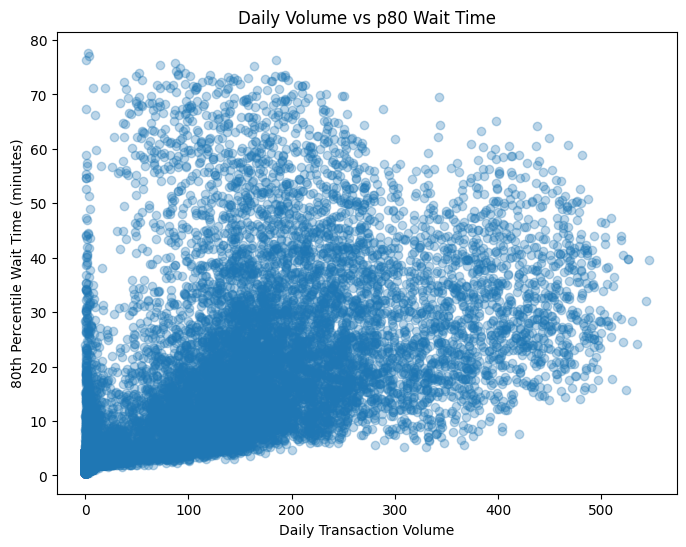

In [64]:
# Basic scatter plot: volume vs p80 wait
plt.figure(figsize=(8, 6))
plt.scatter(
    df_daily["daily_volume"],
    df_daily["p80_wait_min"],
    alpha=0.3
)
plt.xlabel("Daily Transaction Volume")
plt.ylabel("80th Percentile Wait Time (minutes)")
plt.title("Daily Volume vs p80 Wait Time")
plt.show()

In [65]:
# Simple correlation (for reference, not as a modeling claim)
df_daily[["daily_volume", "p80_wait_min"]].corr()

,daily_volume,p80_wait_min
daily_volume,1.000000,0.703415
p80_wait_min,0.703415,1.000000


### Assess variability in wait times at similar demand levels  
Examine the dispersion of branch-level wait times at comparable transaction volumes


<Figure size 1000x600 with 0 Axes>

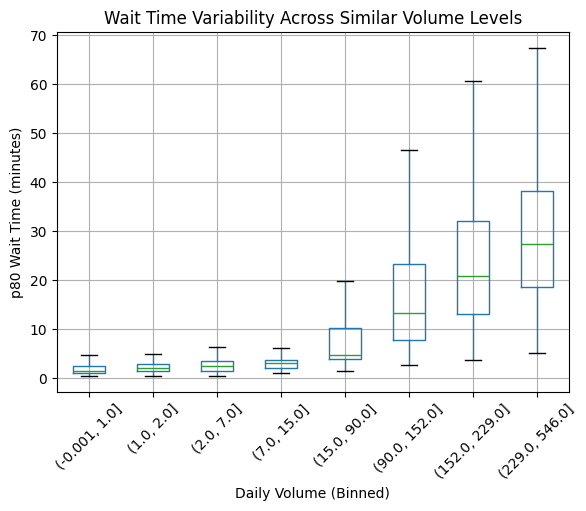

In [66]:
# Bin volume to show dispersion
df_daily["volume_bin"] = pd.qcut(df_daily["daily_volume"], q=10, duplicates="drop")

plt.figure(figsize=(10, 6))
df_daily.boxplot(
    column="p80_wait_min",
    by="volume_bin",
    showfliers=False,
    rot=45
)
plt.xlabel("Daily Volume (Binned)")
plt.ylabel("p80 Wait Time (minutes)")
plt.title("Wait Time Variability Across Similar Volume Levels")
plt.suptitle("")
plt.show()

Although daily volume is strongly associated with wait times, the wide dispersion within volume bands indicates that demand alone is insufficient to reliably predict delays.

### Compare volume–wait relationships across branch deployment models

Stratify the relationship between daily transaction volume and wait times by deployment model to assess whether demand sensitivity differs between internally and externally operated branches.

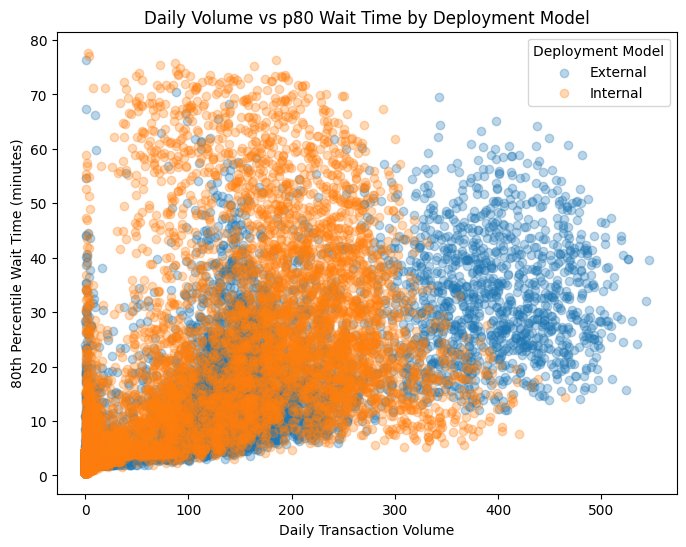

In [67]:
plt.figure(figsize=(8, 6))

for model in df_daily["site_type"].unique():
    subset = df_daily[df_daily["site_type"] == model]
    plt.scatter(
        subset["daily_volume"],
        subset["p80_wait_min"],
        alpha=0.3,
        label=model
    )

plt.xlabel("Daily Transaction Volume")
plt.ylabel("80th Percentile Wait Time (minutes)")
plt.title("Daily Volume vs p80 Wait Time by Deployment Model")
plt.legend(title="Deployment Model")
plt.show()

In [68]:
# Correlation by deployment model (for context)
(
    df_daily
    .groupby("site_type")[["daily_volume", "p80_wait_min"]]
    .corr()
)

daily_volume  p80_wait_min
site_type                                         
External  daily_volume      1.000000      0.786864
          p80_wait_min      0.786864      1.000000
Internal  daily_volume      1.000000      0.683990
          p80_wait_min      0.683990      1.000000

### Key exploratory findings and modeling implications  
Daily transaction volume shows a strong association with high-percentile wait times across branch deployment models, particularly in externally operated locations. 
However, the observed dispersion at similar demand levels suggests that linear models may underfit operational dynamics.

In [69]:
# Save daily dataset for downstream modeling
df_daily.to_csv(r"../data/processed/daily_branch_waits.csv", index=False)